## Import

In [571]:
import requests
import os
import json

import csv
# For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time

### Definimos nuestro Token, id y máximo de resultados

In [572]:

# To set your environment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
# bearer_token = os.environ.get("BEARER_TOKEN")

# Añadir tu BEARER TOKEN de Twitter; para la recolección de datos
bearer_token = ""

# Añadir el id del usuario que vas a 'ver'
user_id = 123955962 # Kast
user_timeline_url = "https://api.twitter.com/2/users/{}/tweets".format(user_id)

# Maximo de resultados, el máximo es 100
max_results = 100

#change params based on the endpoint you are using
query_params = {    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'author_id,text,created_at,lang,public_metrics',
                    'user.fields': '',
                    'place.fields': '',
                    'next_token': {}}


### Definimos autentificación y conexión al Endpoint

In [573]:

def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2FullArchiveSearchPython"
    return r


def connect_to_endpoint(url, params):
    response = requests.request("GET", url, auth=bearer_oauth, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()



### Nos conectamos al endpoint 

In [574]:
json_response = connect_to_endpoint(user_timeline_url, query_params)
print(json.dumps(json_response, indent=4, sort_keys=True))


200
{
    "data": [
        {
            "author_id": "123955962",
            "created_at": "2022-07-23T02:27:58.000Z",
            "id": "1550669018079432705",
            "lang": "es",
            "public_metrics": {
                "like_count": 979,
                "quote_count": 13,
                "reply_count": 62,
                "retweet_count": 454
            },
            "text": "Ya van m\u00e1s de 5.000 encerronas este a\u00f1o, m\u00e1s que todo el 2021. Un record absoluto.\n\n\u00bfY el Presidente Boric? Haciendo campa\u00f1a."
        },
        {
            "author_id": "123955962",
            "created_at": "2022-07-23T02:27:57.000Z",
            "id": "1550669014480760832",
            "lang": "es",
            "public_metrics": {
                "like_count": 327,
                "quote_count": 1,
                "reply_count": 10,
                "retweet_count": 194
            },
            "text": "Si el gobierno del Presidente Boric no puede defender a su

### Ejemplo de guardado JSON

In [575]:

# #guardar los datos en JSON
# with open('data.json', 'w') as f:
#     json.dump(json_response, f)



### Notas de uso para json_response<br>
Existen distintos tipos de datos en json_response, entre ellos está data, includes y meta. Donde se despliegan más atributos

In [576]:
print(json_response["includes"]["users"][0])
username = json_response["includes"]["users"][0]["username"]

# Estructura del JSON:
    # "includes": {
    #     "users": [
    #         {
    #             "id": "123955962",
    #             "name": "Jos\u00e9 Antonio Kast Rist \ud83c\udde8\ud83c\uddf1",
    #             "username": "joseantoniokast"
    #         }
    #     ]
    # },
    # "meta": {
    #     "newest_id": "1550635201231032321",
    #     "next_token": "7140dibdnow9c7btw4228iqkod1io060y37y0rrmnldfd",
    #     "oldest_id": "1546871427252465669",
    #     "result_count": 100
    # }

{'id': '123955962', 'name': 'José Antonio Kast Rist 🇨🇱', 'username': 'joseantoniokast'}


### Ejemplo de guardado CSV

In [577]:
def append_to_csv(json_response, fileName):

    counter = 0
    #Open OR create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in json_response['data']:
        
        # We will create a variable for each since some of the keys might not exist for some tweets
        # So we will account for that

        # 1. Author ID
        # author_id = tweet['author_id']
        
        # 1. Tweet ID
        id_tweet = tweet['id']

        # 2. Time created

        created_at = dateutil.parser.parse(tweet['created_at'])

        # 3. Language
        lang = tweet['lang']

        # 4. Tweet metrics
        retweet_count = tweet['public_metrics']['retweet_count']
        reply_count = tweet['public_metrics']['reply_count']
        like_count = tweet['public_metrics']['like_count']
        quote_count = tweet['public_metrics']['quote_count']

        # 5. Tweet text
        text = tweet['text']
        
        # Assemble all data in a list
        # res = [author_id, created_at, lang, like_count, quote_count, reply_count, retweet_count, text]
        res = [id_tweet,created_at, lang, like_count, quote_count, reply_count, retweet_count, text]
        
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1

    # When done, close the CSV file
    csvFile.close()

In [578]:
#guardar los datos en un CSV
tryagain = True
while(tryagain):
    try:
        os.remove('data.csv')
    except:
        # Create file
        csvFile = open("data.csv", "a", newline="", encoding='utf-8')
        csvWriter = csv.writer(csvFile)

        #Create headers for the data you want to save, in this example, we only want save these columns in our dataset
        csvWriter.writerow(['id_tweet','created_at', 'lang', 'like_count','quote_count','reply_count', 'retweet_count', 'text'])
        csvFile.close()

        tryagain = False

        # llamar la función para añadir lineas al archivo CSV
        append_to_csv(json_response, "data.csv")

### Cargamos la información recopilada del CSV en un dataframe

In [579]:
import pandas as pd

df = pd.read_csv('data.csv')
total_df = len(df)
df.head()

,id_tweet,created_at,lang,like_count,quote_count,reply_count,retweet_count,text
0,1550669018079432705,2022-07-23 02:27:58+00:00,es,979,13,62,454,"Ya van más de 5.000 encerronas este año, más q..."
1,1550669014480760832,2022-07-23 02:27:57+00:00,es,327,1,10,194,Si el gobierno del Presidente Boric no puede d...
2,1550652601523249153,2022-07-23 01:22:44+00:00,es,1825,30,83,1075,El Coordinador de Seguridad Pública de Tarapac...
3,1550635201231032321,2022-07-23 00:13:36+00:00,es,1151,11,97,499,“Estamos preocupados” responde la Ministra Sic...
4,1550634338806546432,2022-07-23 00:10:10+00:00,es,0,0,0,80,RT @JIrarrazavalR: 🔴La ciudadanía necesita la ...


### Normalizamos la fecha para solo tener "Año - Mes - Día"

In [580]:
# Normalizar fecha
# df['created_at'] = pd.to_datetime(df['created_at']).dt.normalize()
df['created_at'] = pd.to_datetime(df['created_at']).dt.date
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')


### Filtramos los RT, y dejamos solo los del usuario

In [581]:
df_noRT = df[df['text'].str.contains("RT @")==False]
total_noRT = len(df_noRT)
print(f"Tweets por parte del usuario: {total_noRT}/{total_df}. Un total de {total_df-total_noRT} RT.")
df_noRT.head()

Tweets por parte del usuario: 75/100. Un total de 25 RT.


,id_tweet,created_at,lang,like_count,quote_count,reply_count,retweet_count,text
0,1550669018079432705,2022-07-23,es,979,13,62,454,"Ya van más de 5.000 encerronas este año, más q..."
1,1550669014480760832,2022-07-23,es,327,1,10,194,Si el gobierno del Presidente Boric no puede d...
2,1550652601523249153,2022-07-23,es,1825,30,83,1075,El Coordinador de Seguridad Pública de Tarapac...
3,1550635201231032321,2022-07-23,es,1151,11,97,499,“Estamos preocupados” responde la Ministra Sic...
5,1550633983184084993,2022-07-23,es,737,5,41,449,"Mientras el Presidente Boric hace campaña, los..."


### Creamos una 'inspección' para el df y la palabra a buscar

In [582]:
# Inspecciona el dataframe; la columna 'texto', la cual contenga la palabra 'word'

# Luego retorna un dataframe con su contenido que contiene y el que no
def createInspection(df, word):
    word = word.lower()
    df_generic = df[(df['text'].str.lower()).str.contains(word)]
    df_doesnt_contain = df[(df['text'].str.lower()).str.contains(word)==False]
    # df_doesnt_contain = df[df['text'].str.contains(word)==False]
    total_generic = len(df_generic)
    print(f"Tweets por parte del usuario, haciendo referencia a {word}: {total_generic}/{len(df)}")
    return df_generic, df_doesnt_contain

# Creando contador en base a fecha; 
def createCounter(df, label):
    df_counter = df['created_at'].dt.date.value_counts().sort_index(ascending=False).reset_index()
    df_counter.columns = ['created_at',label]
    return df_counter

### Creamos los data frames

In [583]:
# Creamos el contenedor (nuevo df) de toda la información de la palabra
word = 'Boric'
df_word, df_wordnt = createInspection(df_noRT, word)
df_word.head()

Tweets por parte del usuario, haciendo referencia a boric: 18/75


,id_tweet,created_at,lang,like_count,quote_count,reply_count,retweet_count,text
0,1550669018079432705,2022-07-23,es,979,13,62,454,"Ya van más de 5.000 encerronas este año, más q..."
1,1550669014480760832,2022-07-23,es,327,1,10,194,Si el gobierno del Presidente Boric no puede d...
2,1550652601523249153,2022-07-23,es,1825,30,83,1075,El Coordinador de Seguridad Pública de Tarapac...
5,1550633983184084993,2022-07-23,es,737,5,41,449,"Mientras el Presidente Boric hace campaña, los..."
6,1550616449722355713,2022-07-22,es,1071,12,47,653,Estamos frente a la intervención política elec...


In [584]:
df_wordnt.head()

,id_tweet,created_at,lang,like_count,quote_count,reply_count,retweet_count,text
3,1550635201231032321,2022-07-23,es,1151,11,97,499,“Estamos preocupados” responde la Ministra Sic...
7,1550612995142692864,2022-07-22,es,716,1,30,360,¿Y en Presidencia no hacen sumarios? https://t...
9,1550591163605798912,2022-07-22,es,3189,81,275,2131,La convención ya no existe: ¿quién está financ...
13,1550202910960599041,2022-07-21,es,11116,74,518,3282,Mientras Contraloría se toma todo el tiempo de...
15,1550145513088901120,2022-07-21,es,3774,34,167,1881,Ministro de Hacienda confirma que subirán las ...


### Se generan las menciones y no menciones

In [585]:
# Creamos el contenedor (nuevo df) de las veces que se menciona y las que no, agrupado en fechas
df_mentions_word = createCounter(df_word,"count")
df_mentions_wordnt = createCounter(df_wordnt,"not count")
display(df_mentions_word.head())
display(df_mentions_wordnt.head())


,created_at,count
0,2022-07-23,4
1,2022-07-22,2
2,2022-07-21,3
3,2022-07-19,2
4,2022-07-15,5


,created_at,not count
0,2022-07-23,1
1,2022-07-22,2
2,2022-07-21,5
3,2022-07-20,5
4,2022-07-19,3


### Juntamos las menciones y no-menciones de la palabra en df_merge

In [586]:
# Juntamos los dataframe de menciones y no-menciones
df_merge = pd.merge(df_mentions_word, df_mentions_wordnt,  how='right', left_on=['created_at'], right_on = ['created_at'])

# Reemplazamos NAN con 0
df_merge['count'] = df_merge['count'].fillna(0)
# Transformamos a int (por alguna razón se estaba pasando a float)
df_merge['count'] = df_merge['count'].apply(int)

display(df_merge.head())
print("Tweets con menciones: ",df_merge["count"].sum(),"\nTweets sin menciones: ",df_merge["not count"].sum())

,created_at,count,not count
0,2022-07-23,4,1
1,2022-07-22,2,2
2,2022-07-21,3,5
3,2022-07-20,0,5
4,2022-07-19,2,3


Tweets con menciones:  18 
Tweets sin menciones:  57


### Graficamos la cantidad de menciones según Fecha

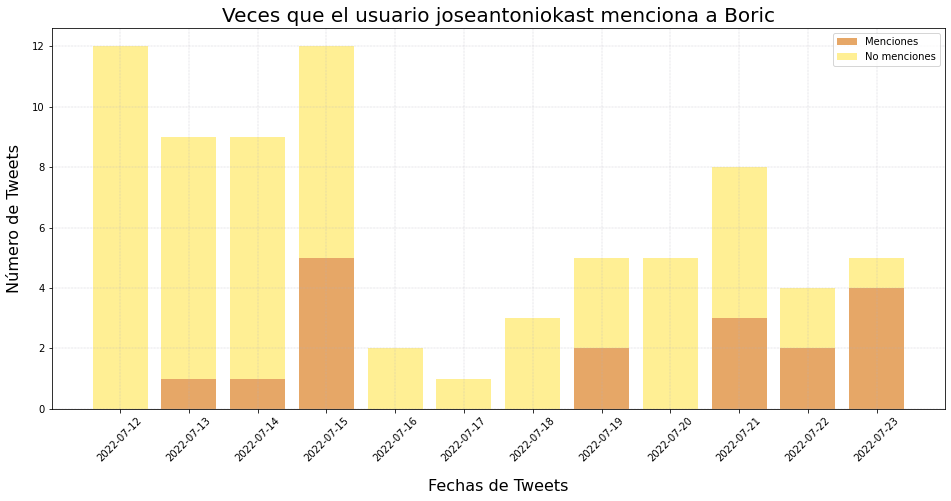

In [587]:
import matplotlib.pyplot as plt


count_array = df_merge['count']
count_array_nt = df_merge['not count']
labels = df_merge['created_at']

fig, ax = plt.subplots(figsize =(16, 7))

ax.bar(labels, count_array, color='#E6A767') # BARRA DE MENCIONES
ax.bar(labels, count_array_nt, bottom=count_array, color='#FFEF94') # BARRA DE NO MENCIONES

ax.legend(["Menciones", "No menciones"])

plt.xticks(labels, rotation =45)
plt.grid(color='#B5B2Bf', linestyle='-.', linewidth=0.3)

ax.set_xlabel("Fechas de Tweets",fontsize=16,labelpad=15)
ax.set_ylabel("Número de Tweets",fontsize=16,labelpad=10)
ax.set_title("Veces que el usuario {} menciona a {}".format(username,word), fontsize=20)
plt.show();

In [588]:
# Revisar una fecha en específico
# df_noRT[df_noRT["created_at"]=="2022-07-15"]]